# Emotion Detection

**Importing Libraries**

In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow Version: ", tf.__version__)

2024-06-18 15:31:57.846932: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 15:31:57.847086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 15:31:58.040187: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow Version:  2.15.0


**Exploring Dataset**

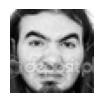

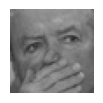

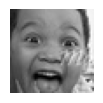

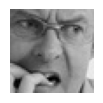

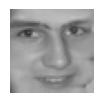

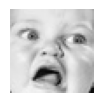

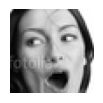

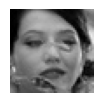

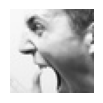

In [2]:
images = glob("/kaggle/input/fer2013/train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize = (5,5))
    plt.subplot(4,4,1+i)
    plt.imshow(cv2.imread(image))
    plt.axis('off')

**Preparing Data For Training**

In [3]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip = True)
train_generator = datagen_train.flow_from_directory("/kaggle/input/fer2013/train/",
                                                    target_size = (img_size, img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)
datagen_validation = ImageDataGenerator(horizontal_flip = True)
validation_generator = datagen_train.flow_from_directory("/kaggle/input/fer2013/test/",
                                                    target_size = (img_size, img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining Model**


In [4]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    return x

In [5]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x

In [6]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,64,(3,3))
    conv_2 = Convolution(conv_1,128,(5,5))
    conv_3 = Convolution(conv_2,512,(3,3))
    conv_4 = Convolution(conv_3,512,(3,3))
    flatten = Flatten()(conv_4)
    dense_1 = Dense_f(flatten, 256)
    dense_2 = Dense_f(dense_1, 512)
    output = Dense(7, activation = "softmax")(dense_2)
    model = Model(inputs = [inputs], outputs = [output])
    opt = Adam(learning_rate = 0.0005)
    model.compile(loss = ['categorical_crossentropy'], optimizer = opt, metrics = ["accuracy"])
    return model

In [7]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,90

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

**Initializing the Model**

In [8]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint(".weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 0.00001)
callbacks = [checkpoint, reduce_lr]

# Training The Model

**The next cell takes time to complete**

In [9]:
history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2651 - loss: 1.9372
Epoch 1: saving model to .weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 733s 2s/step - accuracy: 0.2652 - loss: 1.9368 - val_accuracy: 0.3662 - val_loss: 1.6786 - learning_rate: 5.0000e-04
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 10:22 1s/step - accuracy: 0.4062 - loss: 1.4166
Epoch 2: saving model to .weights.h5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 651us/step - accuracy: 0.4062 - loss: 1.4166 - val_accuracy: 0.4000 - val_loss: 1.4843 - learning_rate: 5.0000e-04
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4183 - loss: 1.5079
Epoch 3: saving model to .weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 684s 2s/step - accuracy: 0.4184 - loss: 1.5078 - val_accuracy: 0.4089 - val_loss: 1.5585 - learning_rate: 5.0000e-04
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 10:32 1s/step - accuracy: 0.3594 - loss: 1.5884
Epoch 4: saving model to .weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 563us/step - accuracy: 0.3594 - loss: 1.5884 - val_accuracy: 0.3000 - val_loss: 1.8617 - learning_rate: 5.0000e-04
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4934 - loss: 1.3251
Epoch 5: saving model to .weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 700s 2s/step - accuracy: 0.4934 - loss: 1.3251 - val_accuracy: 0.5153 - val_loss: 1.2607 - learning_rate: 5.0000e-05
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 10:14

**Model Evaluation**

In [10]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 340ms/step - accuracy: 0.5437 - loss: 1.1930


[1.190973162651062, 0.5410978198051453]

**Plotting Loss**

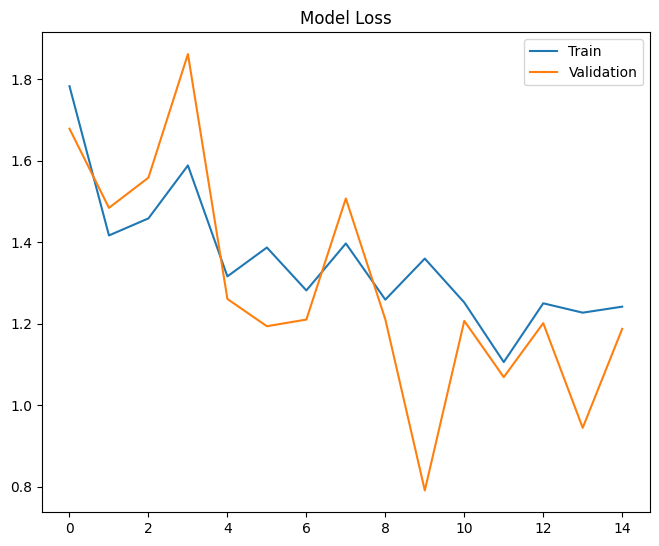

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)


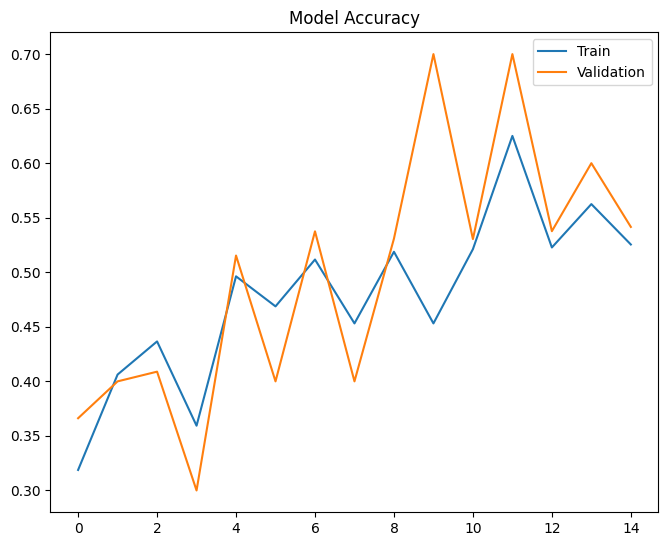

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper right')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)


**Saving Model**

In [13]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)